## Loading packages

In [ ]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner import Celligner
import pandas as pd
# to comment in your case
from depmapomics import tracker as track
#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()

from celligner.params import TISSUE_COLOR

## Loading expression files

In [ ]:
# load from taiga public (figshare link)
# load internal expression,
# latest version can be found at https://depmap.org/portal/download/
# can also be loaded like so pd.read_csv('gs://ccle_default_params/celligner_ex/CCLE_expression.csv.gz', index_col=0)
CCLE_expression = tc.get(name='internal-21q3-fe4c',
                         file='CCLE_expression_full')  


# load  TCGA expression
# this dataset was generated from  ,using this script: 
# caan be found here: pd.read_csv('gs://ccle_default_params/celligner_ex/TCGA_expression.csv.gz', index_col=0)
TCGA_expression = tc.get(name='celligner-input-9827',
                         file='tumor_expression')

In [ ]:
# subset gene names to ensembl ids only
CCLE_expression = CCLE_expression[CCLE_expression.columns[:-92]]
CCLE_expression.columns = list(map(lambda x: x.split(
    ' (')[1][:-1] if ' (' in x else x, CCLE_expression.columns))

common = set(CCLE_expression.columns).intersection(
    set(TCGA_expression.columns))
CCLE_expression = CCLE_expression[list(common)]
TCGA_expression = TCGA_expression[list(common)]

## Managing annotations

In [ ]:
# loading annotations
CCLE_annotation = track.getTracker() # the function uses pygsheets to load this: REFSHEET_URL=https://docs.google.com/spreadsheets/d/1Pgb5fIClGnErEqzxpU7qqX6ULpGTDjvzWwDN8XUJKIY
# Sheets.from_files(MY_ID, MYSTORAGE_ID).get(REFSHEET_URL).sheets[0].to_frame(index_col=0)
# you can also get it from pd.read_csv('gs://ccle_default_params/celligner_ex/CCLE_annotation.csv.gz', index_col=0)


# can be loaded from 
# pd.read_csv('gs://ccle_default_params/celligner_ex/TCGA_annotation.csv.gz', index_col=0)
TCGA_annotation = tc.get(name='celligner-input-9827',
                         file='tumor_annotations') # generated manually 

In [ ]:
# transforming annotations
CCLE_annotation = CCLE_annotation.drop_duplicates('arxspan_id').set_index("arxspan_id")
CCLE_annotation = CCLE_annotation.loc[CCLE_expression.index, ["origin", 'subtype']].rename(columns={"origin": "tissue_type", "subtype": 'disease_type'})
CCLE_annotation["cell_type"] = "CCLE cell line"

TCGA_annotation = TCGA_annotation.set_index("sampleID").loc[TCGA_expression.index,["lineage",
"subtype"]].rename(columns={"lineage":"tissue_type", "subtype": 'disease_type'})
TCGA_annotation['cell_type'] = "TCGA tumor"

In [13]:
rename = {np.nan: "unknown", "adrenal_cortex": "adrenal", "colorectal": "colon", 'thymus': 'thyroid', 'meninges':"central_nervous_system", None: "unknown", 'brain': "central_nervous_system"}

In [ ]:
# some name are not consistent between the two datasets
CCLE_annotation = CCLE_annotation.replace({"tissue_type": rename})
TCGA_annotation = TCGA_annotation.replace({"tissue_type": rename})

## Fitting celliner with the CCLE dataset 

In [ ]:
# issues when rerunning celligner

In [ ]:
my_alligner = Celligner(make_plots=True, priotize_fit=True)
my_alligner.fit(CCLE_expression, CCLE_annotation)

In [4]:
my_alligner.method = "mnn_marioni"
my_alligner.priotize_fit=True
my_alligner.mnn_kwargs = {'k1': 5, 'k2': 50, 'cosine_norm': False, "fk":5}
_ = my_alligner.transform()

reducing dimensionality...


doing differential expression analysis on the clusters..
regressing out the cPCA components..
doing the MNN analysis using Marioni et al. method..
  Looking for MNNs...
  Found 12278 mutual nearest neighbors.
done
reducing dimensionality...
making plot...


In [ ]:
# using the marioni mnn method
my_alligner.method = "mnn_marioni"
my_alligner.priotize_fit=True
my_alligner.mnn_kwargs = {'k1': 5, 'k2': 50, 'cosine_norm': True, "fk":5}
_ = my_alligner.transform(_rerun=False)

In [7]:
my_alligner.umap_kwargs

{'n_neighbors': 15, 'min_dist': 0.2, 'metric': 'cosine', 'n_components': 2}

In [8]:
my_alligner.plot(color_column="tissue_type", colortable=TISSUE_COLOR, umap_kwargs={'n_neighbors': 10,'min_dist': 0.3, 'metric': 'euclidean'})

reducing dimensionality...
making plot...


Figure(id='1762', ...)

In [ ]:
my_alligner.plot(rerun=False)

In [ ]:
# running with regular mnn
my_alligner.method = "mnn"
_ = my_alligner.transform(TCGA_expression, TCGA_annotation)

In [4]:
my_alligner.save('../temp/demo/')

## adding other datasets to celligner

In [2]:
# you can load the dataset from gcp: (you can do so by hand or by installing gsutil)
# (make sure you have the right folder and then do:
# ! gsutil cp gs://celligner/model.pkl ../temp/demo/
my_alligner = Celligner()
my_alligner.load('../temp/demo/')

fetching gene names from biomart cache
using only usefull genes


In [9]:
# met500 
met500_ann = tc.get(name='met500-fc3c', file='met500_ann')
met500_meta = tc.get(name='met500-fc3c', file='met500_meta')
met500_TPM = tc.get(name='met500-fc3c', file='met500_TPM') #20,979x868 matrix

#Novartis_PDX
Novartis_PDX_ann = tc.get(name='pdx-data-3d29', file='Novartis_PDX_ann')
Novartis_PDX_TPM = tc.get(name='pdx-data-3d29', file='Novartis_PDX_TPM').T # 38,087x445

#pediatric_PDX
pediatric_PDX_ann = tc.get(name='pdx-data-3d29', file='pediatric_PDX_ann')
pediatric_PDX_TPM = tc.get(name='pdx-data-3d29', file='pediatric_PDX_TPM') #80,000x250

No dataset version provided. Using version 1.
No dataset version provided. Using version 1.
No dataset version provided. Using version 1.
No dataset version provided. Using version 2.
No dataset version provided. Using version 2.
No dataset version provided. Using version 2.
No dataset version provided. Using version 2.


### Managing annotations

In [14]:
met500_meta["primary_site"] = met500_ann['primary_site'].values
met500_ann = met500_meta.rename(columns={"Sample_id": 'sample_id', 'tissue': 'tissue_type', 'primary_site': "disease_type", "sample_type": "cell_type"}).set_index('sample_id', drop=True)[["tissue_type","disease_type","cell_type"]].replace({"tissue_type":rename, "cell_type": {"tumor": "met500 tumor"}})

In [15]:
pediatric_PDX_ann = pediatric_PDX_ann.rename(columns={"sampleID": 'sample_id', 'lineage': 'tissue_type', 'subtype': "disease_type", "type": "cell_type"}).set_index('sample_id', drop=True)[['cell_type', 'disease_type', 'tissue_type']].replace({"tissue_type":rename})

In [16]:
Novartis_PDX_ann = Novartis_PDX_ann.rename(columns={"sampleID": 'sample_id', 'lineage': 'tissue_type', 'subtype': "disease_type", "type": "cell_type"}).set_index('sample_id', drop=True)[['cell_type', 'disease_type', 'tissue_type']].replace({"tissue_type":rename})

<AxesSubplot:>

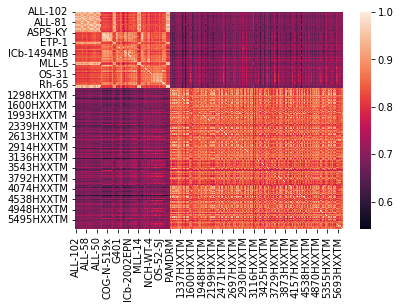

In [17]:
# Looking at dataset similarity
import seaborn as sns
sns.heatmap(pd.concat([pediatric_PDX_TPM.loc[:,set(pediatric_PDX_TPM.columns) & set(Novartis_PDX_TPM.columns)], Novartis_PDX_TPM.loc[:,set(pediatric_PDX_TPM.columns) & set(Novartis_PDX_TPM.columns)]]).T.corr())

In [18]:
Novartis_PDX_TPM = Novartis_PDX_TPM.loc[:,set(Novartis_PDX_TPM)& set(pediatric_PDX_TPM)]
pediatric_PDX_TPM = pediatric_PDX_TPM.loc[:,set(Novartis_PDX_TPM)& set(pediatric_PDX_TPM)]

In [19]:
pediatric_PDX_ann['cell_type'] = "ped PDX"

In [20]:
Novartis_PDX_ann = Novartis_PDX_ann.loc[Novartis_PDX_TPM.index]
pediatric_PDX_ann = pediatric_PDX_ann.loc[pediatric_PDX_TPM.index]

In [21]:
# if you want to align to both CCLE and TCGA, you can ask celligner to consider the two (fit + _pre-transformed_ transform datasets) as a fit dataset by calling:
# my_alligner.putAllToFit()

# you can add your dataset as a dataset to be aligned to, by puting it in fit:
# my_alligner.addToFit(yourdataset).transform()
# /!\ need to already have a transform dataset (if you loaded the example model, this is TCGA)

# you can add your dataset as one to align, by putting it in transform:
# my_alligner.addToTransform(yourdataset)
# /!\ need to already have a fit dataset (if you loaded the example model, this is CCLE)

# if your dataset is small enough it might actually not work well to put it in transform it seems!
# if your dataset is small and similar enough, you can add the parameter dotransform=False (or dofit=False) so that it doesn't fully retransforms or refit but uses cached computation instead.
my_alligner.priotize_fit=False
my_alligner.putAllToFit(redo_diff=False)
_ = my_alligner.transform(met500_TPM, met500_ann, recompute_contamination=False)

clustering...
         Falling back to preprocessing with `sc.pp.pca` and default params.
done
looking at 868 samples.
found 18218 common genes
creating a transform input..
clustering..
         Falling back to preprocessing with `sc.pp.pca` and default params.
reducing dimensionality...


doing differential expression analysis on the clusters..
running differential expression on 35 clusters
running limmapy on the samples
you need to have R installed with the limma library installed
3.4.5
there is 0.235 overlap between the fit and transform dataset in their most variable genes
regressing out the cPCA components..
doing the MNN analysis using Marioni et al. method..
  Looking for MNNs...
  Found 3416 mutual nearest neighbors.
done
reducing dimensionality...
making plot...


In [ ]:
my_alligner.putAllToFit(redo_diff=False)

In [ ]:
_= my_alligner.transform(pd.concat([Novartis_PDX_TPM, pediatric_PDX_TPM]), pd.concat([Novartis_PDX_ann, pediatric_PDX_ann]), recompute_contamination=False)

In [ ]:
from celligner.params import TISSUE_COLOR

In [ ]:
my_alligner.plot(color_column="tissue_type", colortable=TISSUE_COLOR)